<a href="https://colab.research.google.com/github/Jaime-Simoes/TM_Project1/blob/main/Data_Exploration_Catarina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
from nltk.corpus import stopwords
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

#### Load datasets

In [2]:
# Load the main training and testing datasets
train_df = pd.read_excel('C:/Users/ccrei/Downloads/TM_Project1/train.xlsx', index_col='index')
test_df = pd.read_excel('C:/Users/ccrei/Downloads/TM_Project1/test.xlsx', index_col='index')
train_df = train_df.reset_index()
test_df = test_df.reset_index()

# Load the additional training and testing reviews datasets
train_reviews_df = pd.read_excel('C:/Users/ccrei/Downloads/TM_Project1/train_reviews.xlsx')
test_reviews_df = pd.read_excel('C:/Users/ccrei/Downloads/TM_Project1/test_reviews.xlsx')

## 1. Data Exploration

In [3]:
train_df.head()

,index,description,host_about,unlisted
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0


In [4]:
train_df.shape

(6248, 4)

In [5]:
train_reviews_df.head()

,index,comments
0,1,this is a very cozy and comfortable house to s...
1,1,good<br/>
2,1,"My first hostel experience, and all I have to ..."
3,1,Das Hostel war neu und deshalb funktionierte a...
4,1,"It was fine for a dorm, but I think for the pe..."


In [6]:
train_reviews_df.shape

(361281, 2)

In [7]:
test_df.head()

,index,description,host_about
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de..."
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ..."
3,4,Charming Apartment Close to the Bay of Cascais...,:)
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...


In [8]:
test_df.shape

(695, 3)

In [9]:
test_reviews_df.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


In [10]:
test_reviews_df.shape

(41866, 2)

### 1.1. Train dataset

#### Check if train dataset is balanced or unbalanced

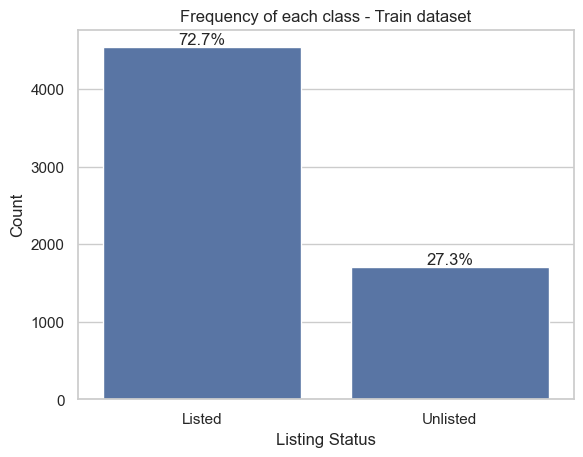

In [11]:
sns.set(style='whitegrid')

label_map = {0: 'Listed', 1: 'Unlisted'}
train_df['count'] = train_df['unlisted'].map(label_map)

# Plot the frequency of each class
ax = sns.countplot(data=train_df, x='count', order=['Listed', 'Unlisted'])

# Calculate percentage of each class
total = len(train_df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.xlabel('Listing Status')
plt.ylabel('Count')
plt.title('Frequency of each class - Train dataset')

plt.show()

In the context of predicting Airbnb property unlisting, the observation that the train dataset is unbalanced is crucial for understanding the distribution of the target variable (listing status) and its implications for model training and evaluation.

Our train dataset is unbalanced, meaning that there is a significant disparity in the number of listed and unlisted properties. More precisely,  72.7% of the properties in the dataset are listed, while only 27.3% are unlisted.

#### Check if the index (Airbnb location) is unique

In [12]:
index_range = range(1, 6249)
unique_indices_train = train_df.index.unique()

if len(unique_indices_train) == len(index_range) and set(unique_indices_train) == set(index_range):
    print("Each index appears once and goes from 1 to 6248")

#### Amount of reviews per place

In [13]:
index_values_train_reviews_df = train_reviews_df['index'].value_counts()
print(index_values_train_reviews_df)

index
265     891
3396    765
1147    678
4106    617
954     583
       ... 
6092      1
376       1
4480      1
1759      1
6139      1
Name: count, Length: 4245, dtype: int64


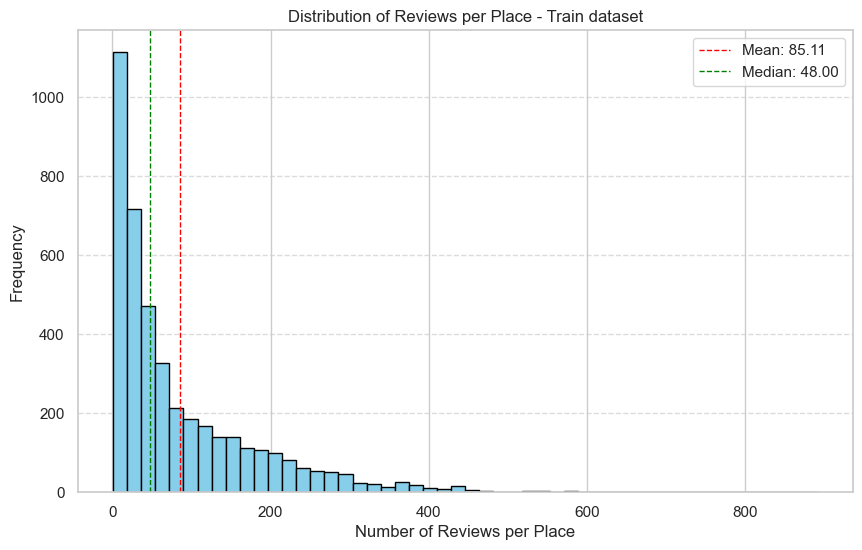

In [14]:
# Calculate the count of reviews per place
review_counts_per_place = train_reviews_df['index'].value_counts()

# Calculate basic statistics
mean_reviews_per_place = review_counts_per_place.mean()
median_reviews_per_place = review_counts_per_place.median()
std_reviews_per_place = review_counts_per_place.std()

# Plot the distribution of reviews per place
plt.figure(figsize=(10, 6))
plt.hist(review_counts_per_place, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_reviews_per_place, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_reviews_per_place:.2f}')
plt.axvline(median_reviews_per_place, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_reviews_per_place:.2f}')
plt.xlabel('Number of Reviews per Place')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Place - Train dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

It's clear that we have right skewed data, which means we have a notable amount of outliers. This way, we will consider that we have around 48 reviews per place, according to the median.
It would also be good to see if the amount of reviews is similar to the listed and unlisted target variables.

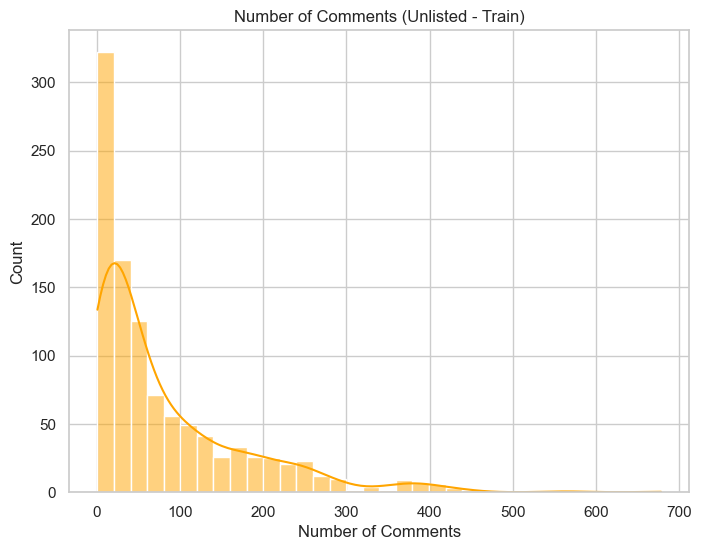

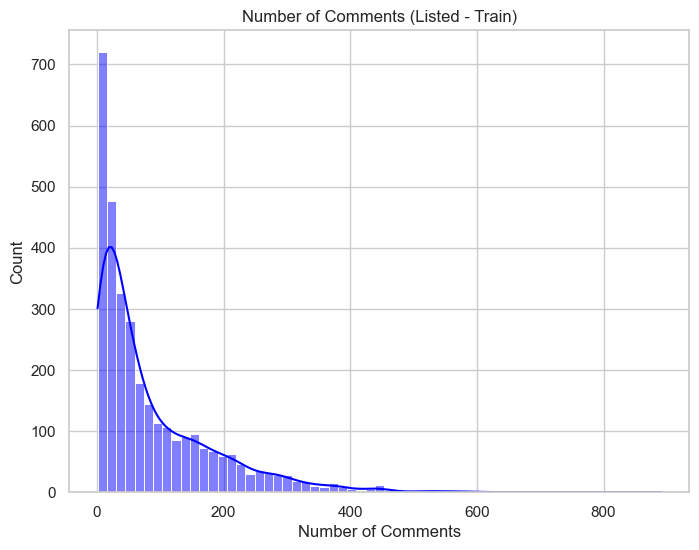

In [15]:
# Calculate the number of comments for each 'index' in the train_reviews_df dataset
comments_count_train = train_reviews_df.groupby('index').count()['comments']

# Merge the train_reviews_df with the train_df based on the index
merged_train_df = train_reviews_df.merge(train_df, left_on='index', right_index=True)

# Filter properties with unlisted=True and unlisted=False
unlisted_true_train = comments_count_train[merged_train_df['unlisted'] == 1]
unlisted_false_train = comments_count_train[merged_train_df['unlisted'] == 0]

# Plot histogram for unlisted=True in the train dataset
plt.figure(figsize=(8, 6))
sns.histplot(data=unlisted_true_train, color='orange', kde=True)
plt.xlabel('Number of Comments')
plt.ylabel('Count')
plt.title('Number of Comments (Unlisted - Train)')
plt.show()

# Plot histogram for unlisted=False in the train dataset
plt.figure(figsize=(8, 6))
sns.histplot(data=unlisted_false_train, color='blue', kde=True)
plt.xlabel('Number of Comments')
plt.ylabel('Count')
plt.title('Number of Comments (Listed - Train)')
plt.show()

The listed places have a lot more comments than the unlisted.

In [16]:
# Merge train_df and train_reviews_df on index
merged_train = train_df.merge(train_reviews_df, on='index')

# Calculate the count of comments for listed and unlisted properties
comments_count_listed = merged_train[merged_train['unlisted'] == 0].groupby('index').count()['comments']
comments_count_unlisted = merged_train[merged_train['unlisted'] == 1].groupby('index').count()['comments']

# Calculate the total count of comments for listed and unlisted properties
total_comments_listed = comments_count_listed.sum()
total_comments_unlisted = comments_count_unlisted.sum()

# Print the total count of comments
print("Total comments for listed properties:", total_comments_listed)
print("Total comments for unlisted properties:", total_comments_unlisted)

Total comments for listed properties: 345895
Total comments for unlisted properties: 15384


In [17]:
# Calculate the median comments per listed and unlisted property
median_comments_listed = comments_count_listed.median()
median_comments_unlisted = comments_count_unlisted.median()

# Print the median comments per property
print("Median comments per listed property:", median_comments_listed)
print("Median comments per unlisted property:", median_comments_unlisted)

Median comments per listed property: 49.0
Median comments per unlisted property: 25.0


We already saw that our data is skewed, so we will use the meadian to understand the average of comments per property.

#### Places that don't have reviews

In [18]:
missing_indexes_train = set(range(1, 6249)) - set(index_values_train_reviews_df.index)
amount_missing = len(missing_indexes_train)      # amount of places with no review

print("Places that don't have reviews:", amount_missing)
print(missing_indexes_train)

Places that don't have reviews: 2003
{2, 3, 4, 6, 7, 13, 15, 17, 18, 21, 22, 28, 34, 41, 46, 48, 50, 52, 57, 60, 64, 67, 72, 74, 75, 77, 82, 84, 85, 87, 89, 92, 93, 94, 95, 96, 102, 103, 104, 108, 114, 115, 117, 118, 121, 125, 132, 135, 136, 138, 139, 143, 151, 157, 158, 160, 166, 170, 176, 178, 180, 186, 187, 189, 191, 200, 202, 206, 209, 213, 215, 216, 228, 231, 234, 236, 237, 239, 240, 252, 255, 256, 258, 260, 261, 263, 264, 266, 267, 268, 271, 276, 281, 284, 286, 288, 296, 297, 299, 302, 304, 306, 308, 316, 323, 324, 335, 343, 349, 362, 363, 364, 372, 379, 380, 383, 385, 387, 393, 397, 401, 402, 403, 410, 422, 434, 438, 443, 447, 450, 451, 455, 457, 460, 463, 469, 473, 476, 477, 478, 481, 482, 483, 485, 488, 489, 491, 492, 502, 506, 512, 513, 516, 522, 525, 533, 541, 543, 544, 546, 548, 556, 561, 562, 563, 571, 574, 580, 582, 587, 588, 594, 600, 605, 610, 615, 621, 625, 627, 628, 629, 630, 633, 635, 637, 638, 646, 647, 654, 655, 656, 657, 662, 666, 667, 669, 670, 676, 677, 678, 686

##### >> Percentage of places with no reviews (very high)

In [19]:
(amount_missing / 6248) * 100

32.058258642765686

### 1.2. Test dataset

#### Check if the index (Airbnb location) is unique

In [20]:
# Count the occurrences of each index (assuming the default integer index)
index_values_test_df = test_df.index.value_counts()

# Print the result
print(index_values_test_df)

0      1
467    1
459    1
460    1
461    1
      ..
233    1
234    1
235    1
236    1
694    1
Name: count, Length: 695, dtype: int64


In [21]:
# Check if the index values are unique
if test_df.index.is_unique:
    print("The index values are unique for all entries.")
else:
    print("The index values are not unique for all entries.")

The index values are unique for all entries.


#### Amount of reviews per place

In [22]:
index_values_test_reviews_df = test_reviews_df['index'].value_counts()
print(index_values_test_reviews_df)

index
160    649
129    571
435    522
418    489
387    461
      ... 
138      1
141      1
38       1
83       1
453      1
Name: count, Length: 475, dtype: int64


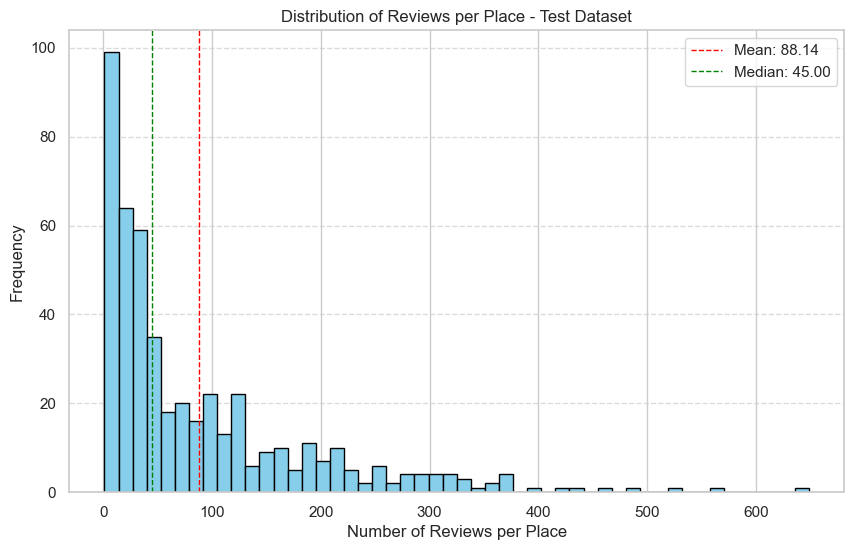

In [23]:
# Calculate the count of reviews per place
review_counts_per_place = test_reviews_df['index'].value_counts()

# Calculate basic statistics
mean_reviews_per_place = review_counts_per_place.mean()
median_reviews_per_place = review_counts_per_place.median()
std_reviews_per_place = review_counts_per_place.std()

# Plot the distribution of reviews per place
plt.figure(figsize=(10, 6))
plt.hist(review_counts_per_place, bins=50, color='skyblue', edgecolor='black')
plt.axvline(mean_reviews_per_place, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_reviews_per_place:.2f}')
plt.axvline(median_reviews_per_place, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_reviews_per_place:.2f}')
plt.xlabel('Number of Reviews per Place')
plt.ylabel('Frequency')
plt.title('Distribution of Reviews per Place - Test Dataset')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

#### Places that don't have reviews

In [24]:
# Get the places that don't have reviews

missing_indexes_test = set(range(1, 695)) - set(index_values_test_reviews_df.index)
amount_missing_test = len(missing_indexes_test)      # amount of places with no review

print("Places that don't have reviews:", amount_missing_test)

Places that don't have reviews: 220


##### >> Percentage of places with no reviews (very high)

In [25]:
(amount_missing_test / 695) * 100      # also high

31.654676258992804

Note from Jaime: The percentage of places that don't have reviews is the same for training and testing. Since we can't change test set we need to also include in the model these situations so, not deleting these rows, but feels very weird. like 1/3 of predictions is on 0 reviews. I don't know...

### 1.3. Duplicated records

In [26]:
train_duplicates = train_df.duplicated().sum()

test_duplicates = test_df.duplicated().sum()

print("Duplicate records in train dataset:", train_duplicates)
print("Duplicate records in test dataset:", test_duplicates)

Duplicate records in train dataset: 0
Duplicate records in test dataset: 0


In the train dataset we have 192 duplicated records, and in the test dataset we have only 4. Probably the 192 duplicated records refer to the same property, since they have same description, host_about and target variable. We decided to consolidate these entries into single properties.

In [27]:
train_df[train_df.duplicated()]

,index,description,host_about,unlisted,count


In [28]:
test_df[test_df.duplicated()]

,index,description,host_about


In [29]:
train_reviews_df[train_reviews_df.duplicated()]

,index,comments
3254,61,Excelente!
4263,70,Everything was great!
6586,144,"Sofia is an incredible host, and made us feel ..."
7362,156,.
12962,254,.
...,...,...
353155,6099,.
353252,6099,Amazing house
353703,6106,Super
358568,6182,Great location!


In [30]:
test_reviews_df[test_reviews_df.duplicated()]

,index,comments
1645,42,Great place
8884,155,Good
11445,178,Great location!
11454,178,Great place!
11829,179,.
16031,246,We had a nice stay and friendly contacts. Than...
16783,255,.
18856,304,.
23799,393,Great location!
30270,480,.


In [31]:
test_reviews_df.head()

,index,comments
0,1,Thank you very much Antonio ! All has been per...
1,1,Very nice appartment in the old town of Lissab...
2,1,When travelling we're looking for kids friendl...
3,1,We've been in Lisbon in march 2013 (3 adults a...
4,1,Our host Antonio was very helpful with informa...


#### Duplicated records handling

In this process, we identified and merged duplicated property records in the train and test datasets, creating a new unique index for each unique property. We then mapped these new indexes to corresponding reviews in the train reviews and test reviews datasets, ensuring accurate association. Finally, duplicates were removed from train and test datasets, and the old index column was dropped.

In [32]:
mapping = train_df.groupby(['description', 'host_about', 'unlisted']).ngroup()

train_reviews_df['index'] = train_reviews_df['index'].map(mapping.to_dict())

train_df.set_index(mapping.values, inplace = True)

train_df.drop_duplicates(inplace = True)

### 1.4. Variables analyses

#### 1.4.1. Description

#### For train dataset

In [33]:
num_unique_descriptions_train = len(train_df['description'].unique())
print("Number of unique descriptions in train dataset:", num_unique_descriptions_train)

Number of unique descriptions in train dataset: 6023


In [34]:
# Get the top 5 most common descriptions and their counts
top_common_descriptions_train = train_df['description'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_descriptions_df = top_common_descriptions_train.reset_index()
top_common_descriptions_df.columns = ['Description', 'Count']

# Display the top 5 common descriptions in a table
print(top_common_descriptions_df)

                                         Description  Count
0                  <b>License number</b><br />Exempt     19
1  Set in a stunning seaside location, this luxur...      6
2  We are The Salty Pelican Yoga & Surf Retreat. ...      6
3  Set in a stunning seaside location, this luxur...      5
4  Located in Chiado district, one of the trendie...      5


#### For test dataset

In [35]:
num_unique_descriptions_test = len(test_df['description'].unique())
print("Number of unique descriptions in test dataset:", num_unique_descriptions_test)

Number of unique descriptions in test dataset: 691


In [36]:
# Get the top 5 most common descriptions and their counts
top_common_descriptions_test = test_df['description'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_descriptions_df = top_common_descriptions_test.reset_index()
top_common_descriptions_df.columns = ['Description', 'Count']

print(top_common_descriptions_df)

                                         Description  Count
0  Nesha Guesthouse Lisbon is a surf & beach orie...      2
1  <b>The space</b><br />Lisbon Nouveau apartment...      2
2  This unique apartment, with an incredible view...      2
3  Book now a bed, at Impact House Belém, a hoste...      2
4  <b>The space</b><br />Apartment located in the...      1


#### 1.4.2. Host_about

#### For train dataset

In [37]:
num_unique_host_about_train = len(train_df['host_about'].unique())
print("Number of unique host_about in train dataset:", num_unique_host_about_train)

Number of unique host_about in train dataset: 2803


In [38]:
# Get the top 5 most common descriptions and their counts
top_common_host_about_train = train_df['host_about'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_host_about_df = top_common_host_about_train.reset_index()
top_common_host_about_columns = ['host_about', 'Count']

# Display the top 5 common host_about in a table
print(top_common_host_about_df)

                                          host_about  count
0  We are Feels Like Home Holiday Rentals.\nA com...    153
1  Dear guest.\n\nWe take pride in helping thousa...     93
2  Founded by travel enthusiasts (just like you) ...     66
3  Hi there!\n\nWe're GuestReady, a professional ...     62
4  Hi, we are Homing - a company that develops it...     43


#### For test dataset

In [39]:
num_unique_host_about_test = len(test_df['host_about'].unique())
print("Number of unique host_about in test dataset:", num_unique_host_about_test)

Number of unique host_about in test dataset: 550


In [40]:
# Get the top 5 most common descriptions and their counts
top_common_host_about_test = test_df['host_about'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_host_about_df = top_common_host_about_test.reset_index()
top_common_host_about_df.columns = ['host_about', 'Count']

print(top_common_host_about_df)

                                          host_about  Count
0  We are Feels Like Home Holiday Rentals.\nA com...     14
1  Dear guest.\n\nWe take pride in helping thousa...     14
2  Hello! We are Camila and Paulo! Parents of tri...      6
3  Hi there!\n\nWe're GuestReady, a professional ...      5
4  Hi there!\n\nWe're GuestReady, a professional ...      5


#### 4.4.3. Comments

In [41]:
# Get the top 5 most common descriptions and their counts
top_common_comments_train = train_reviews_df['comments'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_comments_df = top_common_comments_train.reset_index()
top_common_comments_columns = ['comments', 'Count']

# Display the top 5 common comments in a table
print(top_common_comments_df)

          comments  count
0                .    449
1  Great location!    131
2   Great location    123
3     Great place!    110
4      Great place     96


In [42]:
# Get the top 5 most common descriptions and their counts
top_common_comments_test = test_reviews_df['comments'].value_counts().head()

# Convert the result to a DataFrame for better visualization
top_common_comments_df = top_common_comments_test.reset_index()
top_common_comments_columns = ['comments', 'Count']

# Display the top 5 common comments in a table
print(top_common_comments_df)

          comments  count
0                .     69
1  Great location!     23
2     Great place!     15
3      Great place     14
4   Great location     13


### 1.5. Missing values

#### 1.5.1. Description

In [43]:
# Count missing values in the 'description' column
missing_description_count = train_df['description'].isnull().sum()

# Display the count of missing values
print("Missing values in 'description' column:", missing_description_count)


Missing values in 'description' column: 0


In [44]:
# Count missing values in the 'description' column
missing_description_count = test_df['description'].isnull().sum()

# Display the count of missing values
print("Missing values in 'description' column:", missing_description_count)


Missing values in 'description' column: 0


We already saw that we have 19 entries saying " <b>License number</b><br />Exempt ". This entry can be seen as a missing value because it doesn't provide any information, it's probably just a default description. For entries that start with that expression, or that have less than 17 characters before the appearance of that expression, we will consider it an empty string.

In [45]:
# Replace entries starting with "<b>License number</b>" with an empty string
train_df.loc[train_df['description'].str.startswith('<b>License number</b>'), 'description'] = ''

In [46]:
import re

# Define a regular expression pattern to match observations ending with "License Number"
pattern = r'^.{0,17}License Number$'  # Match up to 17 characters before "License Number"

# Replace matching entries with an empty string
train_df['description'] = train_df['description'].str.replace(pattern, '', regex=True)

In [47]:
# Replace entries starting with "<b>License number</b>" with an empty string
test_df.loc[test_df['description'].str.startswith('<b>License number</b>'), 'description'] = ''

In [48]:
import re

# Define a regular expression pattern to match observations ending with "License Number"
pattern = r'^.{0,17}License Number$'  # Match up to 17 characters before "License Number"

# Replace matching entries with an empty string
test_df['description'] = test_df['description'].str.replace(pattern, '', regex=True)

#### 4.5.1. Host_about

In [49]:
# Count missing values in the 'host_about' column
missing_host_about_count = train_df['host_about'].isnull().sum()

# Display the count of missing values
print("Missing values in 'host_about' column:", missing_host_about_count)

Missing values in 'host_about' column: 0


In [50]:
# Count missing values in the 'host_about' column of test_df
missing_host_about_count_test = test_df['host_about'].isnull().sum()

# Display the count of missing values
print("Missing values in 'host_about' column in test_df:", missing_host_about_count_test)

Missing values in 'host_about' column in test_df: 0


In the host_about variable we have some entries containing weird characters. These expressions will be removed in the section "Punctuation" in the Preprocessing.

In [51]:
missing_markers = ['', '.', '...', ':)', '-', '_', ':-)', '_x000D_', '_x000D__x000D_', '_x000D__x000D__x000D__x000D__x000D__x000D__x000D__x000D_', '@ZMPoppe', 'None', '_x000D_\n', np.nan, '\n', '!']

missing_values_host_about = train_df['host_about'].isin(missing_markers).sum()

print("Missing values in 'host_about' column:", missing_values_host_about)

Missing values in 'host_about' column: 46


#### 4.5.1. Comments

In [52]:
train_reviews_df[train_reviews_df['comments'].apply(lambda x: len(str(x)) < 5)].head(30)

,index,comments
39,3630.0,top
275,5642.0,.
317,2570.0,I
432,2570.0,👍
580,4215.0,Good
682,4215.0,.
698,4215.0,q
822,532.0,👍
1129,4034.0,-
1244,4034.0,.


In [53]:
import emoji

# Define the threshold for considering comments as missing values based on length
threshold_length = 5

# Define the list of encodings representing sentiment-based comments
expressions_to_keep = ['5/5', 'ótima', 'A', 'A+', 'A++', 'A+++', 'A++++', 'super', 'good', 'top', 'ok', 'bom', 'bien', 'nice', 'cool', 'easy', 'love', 'like', 'happy', 'great', 'fine', 'cute', 'warm', 'kind', 'fair', 'safe', 'fast', 'free']

In [54]:
delete_reviews_train = train_reviews_df[train_reviews_df['comments'].apply(lambda x: len(str(x)) <= threshold_length and emoji.emoji_count(str(x))==0 and str(x).lower() not in expressions_to_keep)]
delete_reviews_train

,index,comments
275,5642.0,.
317,2570.0,I
682,4215.0,.
698,4215.0,q
1129,4034.0,-
...,...,...
359303,3376.0,.
359338,1121.0,Aucun
359456,2129.0,1
359648,2129.0,Nan


In [55]:
# Get the index of rows to delete
rows_to_delete = delete_reviews_train.index

# Drop the rows from test_reviews_df
train_reviews_df.drop(rows_to_delete, inplace=True)

In [56]:
train_reviews_df.shape

(360104, 2)

We already saw that we have 449 entries with a point ".", this entries are indeed missing values. We also have 1012 comments that can be seen as missing values because they are so short, they barely provide any value. We will keep some particular cases where the host comment "nice", "ok" or "5/5", for example, because despite being short comments, they do have a meaning. The rest will be considered missing value. For now we will keep the emojis because in the Preprocessing we will replace them with their meaning/definition.

In [57]:
test_reviews_df[test_reviews_df['comments'].apply(lambda x: len(str(x)) < 5)].head(30)

,index,comments
808,21,top
1004,33,Top
1077,34,.
1174,35,.
1232,36,B
1466,39,ok
1890,45,x
2166,49,-
2717,54,.
2994,58,😁


In [58]:
delete_reviews_test = test_reviews_df[test_reviews_df['comments'].apply(lambda x: len(str(x)) <= threshold_length and emoji.emoji_count(str(x))==0 and str(x).lower() not in expressions_to_keep)]
delete_reviews_test

,index,comments
1077,34,.
1174,35,.
1232,36,B
1890,45,x
2166,49,-
...,...,...
39183,646,A+++
40526,673,.
41128,687,.
41648,692,.


In [59]:
# Get the index of rows to delete
rows_to_delete = delete_reviews_test.index

# Drop the rows from test_reviews_df
test_reviews_df.drop(rows_to_delete, inplace=True)

In [60]:
test_reviews_df.shape # We had 41866 records before, so we removed 157 records.

(41709, 2)

### 1.6. Merge datasets

In [61]:
train_reviews_df['comments'] = train_reviews_df['comments'].astype(str)

# Group comments by index and join them with " ## "
comments_grouped = train_reviews_df.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()

# Merge with train_df_cleaned
train_df = train_df.merge(comments_grouped, how='left', on='index')

In [62]:
train_df.head()

,index,description,host_about,unlisted,count,comments
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,"wonderful location. flat is spacious, beautifu..."
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,"Apartamento muito bonitinho, bem decorado e eq..."
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,Listed,NaN
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Listed,NaN


In [63]:
test_reviews_df['comments'] = test_reviews_df['comments'].astype(str)
test_comments_grouped = test_reviews_df.groupby('index')['comments'].apply(lambda x: ' '.join(x)).reset_index()
test_df = test_df.merge(test_comments_grouped, how='left', on='index')

In [64]:
test_df.head()

,index,description,host_about,comments
0,1,<b>The space</b><br />Apartment located in the...,"Gosto de viajar, de conhecer pessoas, gosto de...",Thank you very much Antonio ! All has been per...
1,2,"IMPORTANT: In response to COVID-19, this prope...",We are the be@home Team!\n\nYou can count on u...,"This is a beautiful, bright apartment in a mor..."
2,3,"Bright, beautiful, and spacious. This four-bed...","Hi there!\n\nWe're GuestReady, a professional ...",NaN
3,4,Charming Apartment Close to the Bay of Cascais...,:),Claudia was a great host. She met us at the t...
4,5,"Se procura umas férias perto da praia, casino ...",Bem vindos a Portugal!_x000D_\nAdoro o meu Paí...,La maison est exactement comme sur les photos....


At this point we have only two datasets: "train_df" and "test_df".

### 1.7. Languages 

Here we are adding a column to each one of our datasets where we say the language used in each one of the records.

In [65]:
from langdetect import detect
from collections import Counter

# Function to detect language
def language_detection(x):
    try:
        return detect(x)
    except:
        return 'error'

# Apply language detection to the 'description' column in train_df
train_df['language'] = train_df['description'].apply(lambda x: language_detection(str(x)))

# Apply language detection to the 'description' column in test_df
test_df['language'] = test_df['description'].apply(lambda x: language_detection(str(x)))

# Display the first few rows of train_df to verify the addition of the 'language' column
print("First few rows of train_df with 'language' column:")
print(train_df.head())

# Display the first few rows of test_df to verify the addition of the 'language' column
print("\nFirst few rows of test_df with 'language' column:")
print(test_df.head())

First few rows of train_df with 'language' column:
   index                                        description  \
0      1  This is a shared mixed room in our hostel, wit...   
1      2  O meu espaço fica perto de Parque Eduardo VII,...   
2      3  Trafaria’s House is a cozy and familiar villa ...   
3      4  Apartamento Charmoso no Chiado, Entre o Largo ...   
4      5  Joli appartement  en bordure de mer.<br /> 2 m...   

                                          host_about  unlisted     count  \
0                Alojamento Local Registro: 20835/AL         0    Listed   
1  I am friendly host, and I will try to always b...         1  Unlisted   
2  I am a social person liking to communicate, re...         1  Unlisted   
3  Hello!_x000D_\nI m Portuguese and i love to me...         0    Listed   
4  Nous sommes une famille avec deux enfants de 1...         0    Listed   

                                            comments language  
0  wonderful location. flat is spacious, beautifu

In [66]:
# Calculate the percentage of each language in train_df
train_lang_counts = train_df['language'].value_counts(normalize=True) * 100

# Calculate the percentage of each language in test_df
test_lang_counts = test_df['language'].value_counts(normalize=True) * 100

# Display the percentages for train_df
print("Percentage of each language in train_df:")
print(train_lang_counts)

# Display the percentages for test_df
print("\nPercentage of each language in test_df:")
print(test_lang_counts)

Percentage of each language in train_df:
language
en       81.177977
pt       14.516645
error     1.392446
fr        1.344430
de        0.736236
es        0.432138
da        0.160051
no        0.048015
ca        0.048015
it        0.048015
zh-cn     0.048015
nl        0.032010
sv        0.016005
Name: proportion, dtype: float64

Percentage of each language in test_df:
language
en       82.733813
pt       13.812950
error     1.438849
fr        0.863309
de        0.287770
es        0.287770
da        0.287770
no        0.143885
ca        0.143885
Name: proportion, dtype: float64


We have identified several languages in the train dataset. English is the most common, around 81.6% of both datasets. Portuguese follows, representing approximately 14%. Other languages include French, Danish, and German, each comprising less than 2% of the dataset. The remaining languages such as Spanish, Norwegian, Catalan, Chinese, Italian, Dutch, and Swedish have a combined presence of less than 1%.

### 1.8. World Cloud (needs to be after duplicated records handling)

In [67]:
# Calculate word count for the "description" column
train_df['description_word_count'] = train_df['description'].apply(lambda x: len(str(x).split(" ")))

# Calculate word count for the "host_about" column
train_df['host_about_word_count'] = train_df['host_about'].apply(lambda x: len(str(x).split(" ")))

# Calculate word count for the "comments" column
train_df['comments_word_count'] = train_df['comments'].apply(lambda x: len(str(x).split(" ")))

In [68]:
train_df.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
0,1,"This is a shared mixed room in our hostel, wit...",Alojamento Local Registro: 20835/AL,0,Listed,"wonderful location. flat is spacious, beautifu...",en,127,4,2657
1,2,"O meu espaço fica perto de Parque Eduardo VII,...","I am friendly host, and I will try to always b...",1,Unlisted,NaN,pt,23,24,1
2,3,Trafaria’s House is a cozy and familiar villa ...,"I am a social person liking to communicate, re...",1,Unlisted,"Apartamento muito bonitinho, bem decorado e eq...",en,170,45,32
3,4,"Apartamento Charmoso no Chiado, Entre o Largo ...",Hello!_x000D_\nI m Portuguese and i love to me...,0,Listed,NaN,pt,47,31,1
4,5,Joli appartement en bordure de mer.<br /> 2 m...,Nous sommes une famille avec deux enfants de 1...,0,Listed,NaN,fr,101,37,1


In [69]:
train_df.description_word_count.describe()

count    6248.000000
mean      132.832907
std        48.160638
min         1.000000
25%        99.000000
50%       157.000000
75%       167.000000
max       210.000000
Name: description_word_count, dtype: float64

In [70]:
train_df.host_about_word_count.describe()

count    6248.000000
mean       73.653009
std        79.660191
min         1.000000
25%        26.000000
50%        55.000000
75%       101.000000
max      1387.000000
Name: host_about_word_count, dtype: float64

In [71]:
train_df.comments_word_count.describe()

count     6248.000000
mean      2771.849392
std       4607.597784
min          1.000000
25%          1.000000
50%        741.500000
75%       3477.750000
max      49308.000000
Name: comments_word_count, dtype: float64

In [72]:
# Get most frequent 'words' for all three columns

# Convert each description to string before joining
description_words = ' '.join(train_df['description'].apply(str)).split()
description_freq = pd.Series(description_words).value_counts()
top_10_description_words = description_freq.head(10)

# Convert each host_about to string before joining
host_about_words = ' '.join(train_df['host_about'].apply(str)).split()
host_about_freq = pd.Series(host_about_words).value_counts()
top_10_host_about_words = host_about_freq.head(10)

# Convert each comment to string before joining
comments_words = ' '.join(train_df['comments'].apply(str)).split()
comments_freq = pd.Series(comments_words).value_counts()
top_10_comments_words = comments_freq.head(10)

print("Top 10 most frequent words in the 'description' column:")
print(top_10_description_words)
print("\nTop 10 most frequent words in the 'host_about' column:")
print(top_10_host_about_words)
print("\nTop 10 most frequent words in the 'comments' column:")
print(top_10_comments_words)

Top 10 most frequent words in the 'description' column:
the      31323
and      27698
a        25540
/><br    17380
to       15328
of       15122
in       13866
with     13649
is       12083
de        6918
Name: count, dtype: int64

Top 10 most frequent words in the 'host_about' column:
and    16358
to     13291
the    10797
a      10535
in      9860
of      6524
I       6419
you     6248
de      4325
We      4206
Name: count, dtype: int64

Top 10 most frequent words in the 'comments' column:
and     552720
the     515610
a       398289
to      328374
is      257978
in      249304
was     239568
of      174004
very    156512
The     143895
Name: count, dtype: int64


The most frequent words are "stop words".

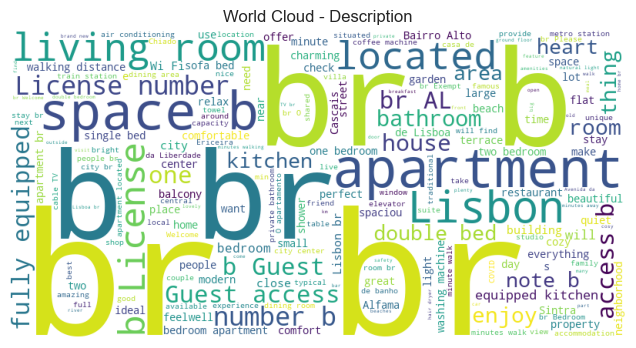

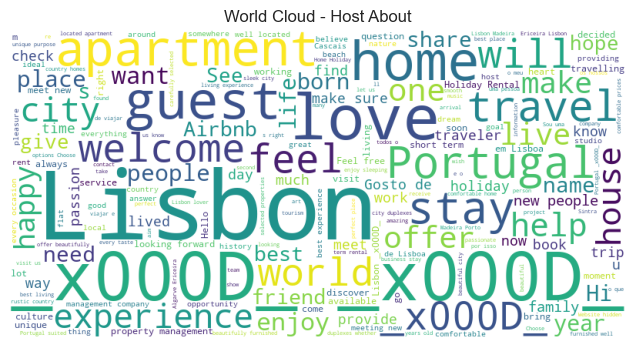

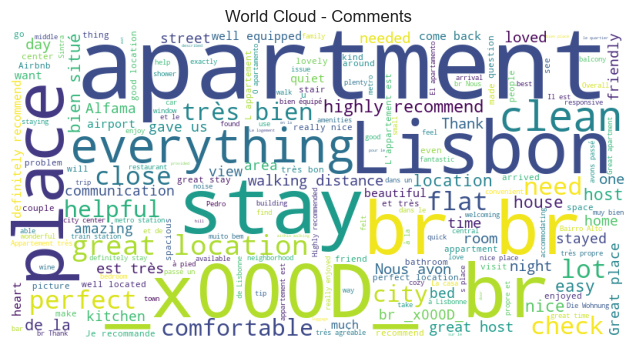

In [73]:
def wordcloud(column, title):
    # Convert each element in the column to string before joining
    text = ' '.join(map(str, column))

    # Create WordCloud object
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

    # Plotting the word cloud
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

wordcloud(train_df['description'], 'World Cloud - Description')
wordcloud(train_df['host_about'], 'World Cloud - Host About')
wordcloud(train_df['comments'], 'World Cloud - Comments')

#### Separate each word using a list

In [74]:
# Separating into list with each element being one word

train_df['description'] = train_df['description'].str.split()
train_df['host_about'] = train_df['host_about'].str.split()
train_df['comments'] = train_df['comments'].str.split()

In [75]:
train_df.head()

,index,description,host_about,unlisted,count,comments,language,description_word_count,host_about_word_count,comments_word_count
0,1,"[This, is, a, shared, mixed, room, in, our, ho...","[Alojamento, Local, Registro:, 20835/AL]",0,Listed,"[wonderful, location., flat, is, spacious,, be...",en,127,4,2657
1,2,"[O, meu, espaço, fica, perto, de, Parque, Edua...","[I, am, friendly, host,, and, I, will, try, to...",1,Unlisted,NaN,pt,23,24,1
2,3,"[Trafaria’s, House, is, a, cozy, and, familiar...","[I, am, a, social, person, liking, to, communi...",1,Unlisted,"[Apartamento, muito, bonitinho,, bem, decorado...",en,170,45,32
3,4,"[Apartamento, Charmoso, no, Chiado,, Entre, o,...","[Hello!_x000D_, I, m, Portuguese, and, i, love...",0,Listed,NaN,pt,47,31,1
4,5,"[Joli, appartement, en, bordure, de, mer.<br, ...","[Nous, sommes, une, famille, avec, deux, enfan...",0,Listed,NaN,fr,101,37,1


In [76]:
# Doing the same for test set

test_df['description'] = test_df['description'].str.split()
test_df['host_about'] = test_df['host_about'].str.split()
test_df['comments'] = test_df['comments'].str.split()

In [77]:
test_df.head()

,index,description,host_about,comments,language
0,1,"[<b>The, space</b><br, />Apartment, located, i...","[Gosto, de, viajar,, de, conhecer, pessoas,, g...","[Thank, you, very, much, Antonio, !, All, has,...",en
1,2,"[IMPORTANT:, In, response, to, COVID-19,, this...","[We, are, the, be@home, Team!, You, can, count...","[This, is, a, beautiful,, bright, apartment, i...",en
2,3,"[Bright,, beautiful,, and, spacious., This, fo...","[Hi, there!, We're, GuestReady,, a, profession...",NaN,en
3,4,"[Charming, Apartment, Close, to, the, Bay, of,...",[:)],"[Claudia, was, a, great, host., She, met, us, ...",en
4,5,"[Se, procura, umas, férias, perto, da, praia,,...","[Bem, vindos, a, Portugal!_x000D_, Adoro, o, m...","[La, maison, est, exactement, comme, sur, les,...",pt


### Merge datasets

>>>> Making new datasets for savety

In [78]:
# Might be this that is blowing up RAM

train_df_2 = train_df
test_df_2 = test_df

## 5. Data Preprocessing

### 5.1. Text Standardization Techniques

### Lower case

In [82]:
train_df_2['description'] = train_df_2['description'].apply(lambda x: [word.lower() for word in x])
train_df_2['host_about'] = train_df_2['host_about'].apply(lambda x: [word.lower() for word in x])
train_df_2['comments'] = train_df_2['comments'].apply(lambda x: [word.lower() for word in x])

train_df_2.head()

TypeError: 'float' object is not iterable

In [80]:
test_df_2['description'] = test_df_2['description'].apply(lambda x: [word.lower() for word in x])
test_df_2['host_about'] = test_df_2['host_about'].apply(lambda x: [word.lower() for word in x])
test_df_2['comments'] = test_df_2['comments'].apply(lambda x: [word.lower() for word in x])

test_df_2.head()

TypeError: 'float' object is not iterable

### Remove HTML tags and special characters

In [ ]:
def clean_text(words):

    # first join everything
    text = ' '.join(words)

    # what to remove
    pattern = re.compile(r'<[^>]*>|<br\s*/?>|_x000d_')

    # replace by empty string
    cleaned_text = re.sub(pattern, '', text)

    cleaned_words = cleaned_text.split()

    return cleaned_words

# Apply to dfs to remove symbols

columns_to_clean_train = ["description", "host_about", "comments"]

for column in columns_to_clean_train:
    train_df_2[column] = train_df_2[column].apply(clean_text)

columns_to_clean_test = ["description", "host_about", "comments"]

for column in columns_to_clean_test:
    test_df_2[column] = test_df_2[column].apply(clean_text)

HTML (Hypertext Markup Language) is the standard language for creating web pages. It uses tags enclosed in angle brackets to structure content. When cleaning text data, removing HTML tags involves stripping these elements to obtain the raw text content. Also, removing special characters is a common step in text preprocessing because they often do not add meaningful information. Special characters such as punctuation marks and symbols can introduce noise.

In [ ]:
test_df_2.head()

### Stop words

In [ ]:
from nltk.corpus import stopwords
import re

# Define stop words for each language
stop_words = {
    "en": set(stopwords.words('english')),
    "pt": set(stopwords.words('portuguese')),
    "fr": set(stopwords.words('french')),
    "da": set(stopwords.words('danish')),
    "de": set(stopwords.words('german')),
    "es": set(stopwords.words('spanish')),
    "no": set(stopwords.words('norwegian')),
    "ca": set(stopwords.words('catalan')),
    "zh-cn": set(stopwords.words('chinese')),
    "it": set(stopwords.words('italian')),
    "nl": set(stopwords.words('dutch')),
    "sv": set(stopwords.words('swedish'))
}

# Function to remove stop words based on language
def remove_stop_words(text, language):
    stop = stop_words.get(language, None)
    if stop:
        return " ".join([word for word in text.split() if word not in stop])
    else:
        return text

# Apply stop words removal to the 'description' column based on language
train_df['description'] = train_df.apply(lambda x: remove_stop_words(str(x['description']), x['language']), axis=1)

In this step we are removing common stopwords across multiple languages using the Natural Language Toolkit (NLTK) library.

### Regular Expressions 

In [ ]:
def regular_currency(text):
    regular_text = re.sub(r'[$€£]\d+(\.\d+)?', '#COST', text)
    regular_text = re.sub(r'\b\d+\s?(USD|EUR|GBP)\b', '#COST', text)
    regular_text = re.sub(r'\b\d+\s?(dollars|euros|pounds)\b', '#COST', text)
    return regular_text

def regular_dates(text):
    regular_text = re.sub(r'(\d{1,2})/(\d{1,2})/(\d{4})', r'\3-\1-\2', text)
    regular_text = re.sub(r'(\d{4})-(\d{1,2})-(\d{1,2})', r'\3/\2/\1', text)
    return regular_text

def regular_measurements(text):
    regular_text = re.sub(r'\bm(eters)?\b', 'meter', text)
    regular_text = re.sub(r'\b(km|kilometers)\b', 'kilometer', text)
    regular_text = re.sub(r'\b(miles|mi)\b', 'mile', text)
    return regular_text

def regular_abbreviations(text):
    abbreviations = {
        'USA': 'united states of america',
        'UK': 'united kingdom',
        'US': 'united states',
        'EU': 'european union',
    }
    for abbreviation, full_form in abbreviations.items():
        text = re.sub(r'\b{}\b'.format(abbreviation), full_form, text)
    return text

def regular_email_addresses(text):
  """
  Replaces email addresses in a given text with a generic placeholder.
  """
  email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'
  regular_text = re.sub(email_pattern, 'email', text)
  return regular_text

def regular_web_links(text):
  """
  Replaces urls in a given text with a generic placeholder.
  """
  url_pattern = r'http\S+|www\S+'
  regular_text = re.sub(url_pattern, 'url', text)
  return regular_text

def regular_spelling(text):
    spelling_variations = {
        'colour': 'color',
        'favourite': 'favorite',
        'centre': 'center',
        'travelling': 'traveling',
        'organisation': 'organization',
        'recognise': 'recognize',
        'cheque': 'check',
        'catalogue': 'catalog',
        'neighbour': 'neighbor',
    }

    for misspelling, correct_spelling in spelling_variations.items():
        text = re.sub(r'\b{}\b'.format(misspelling), correct_spelling, text)
    return text

In [ ]:
def apply_normalization(column, df):
    for i, row in df.iterrows():
        normalized_column = []
        for element in row[column]:
            element = regular_currency(element)
            element = regular_dates(element)
            element = regular_measurements(element)
            element = regular_abbreviations(element)
            element = regular_email_addresses(element)
            element = regular_web_links(element)
            element = regular_spelling(element)
            normalized_column.append(element)
        df.at[i, column] = normalized_column
    return df


columns_to_normalize = ['description', 'host_about', 'comments']
for column in columns_to_normalize:
    train_df_2 = apply_normalization(column, train_df_2)
    test_df_2 = apply_normalization(column, test_df_2)

### Contractions - Extra 

This step needs to come before punctuation, otherwise it doesn't work.

In [ ]:
contractions_dict = {
    # English contractions
    "ain't": "are not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I would",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it would",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "shan't": "shall not",
    "she'd": "she would",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that's": "that is",
    "there'd": "there would",
    "there'll": "there will",
    "there're": "there are",
    "there's": "there is",
    "they'd": "they would",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "y'all": "you all",
    "you'd": "you would",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",

    # French contractions
    "c'est": "ce est",
    "qu'il": "que il",
    "n'est": "ne est",
    "l'a": "la a",
    "j'ai": "je ai",
    "d'un": "de un",
    "s'est": "se est",

    # Spanish contractions
    "d'el": "de el",
    "al": "a el",
    "del": "de el",
    "como": "cómo",
    "según": "según",
    "está": "esta",
    "esos": "esos",

    # Portuguese contractions
    "da": "de a",
    "das": "de as",
    "do": "de o",
    "dos": "de os",
    "na": "em a",
    "nas": "em as",
    "no": "em o",
    "nos": "em os",
}

def expand_contractions(text, language):
    contractions = contractions_dict.get(language, {})
    for contraction, expansion in contractions.items():
        text = text.replace(contraction, expansion)
    return text

# Example usage
english_text = "I can't believe it."
expanded_english = expand_contractions(english_text, "en")
print("Expanded English:", expanded_english)

french_text = "C'est la vie."
expanded_french = expand_contractions(french_text, "fr")
print("Expanded French:", expanded_french)

### Punctuation

In [ ]:
def remove_punctuation(text):
    return [re.sub(r'[^\w\s]', '', word) for word in text]

def applying(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            df[column] = df[column].apply(remove_punctuation)
    return df

train_df_2 = applying(train_df_2)
test_df_2 = applying(test_df_2)

In [ ]:
test_df_2.head()

### Stemming and lemmatization

Stemming is chosen over lemmatization due to the complexity involved in handling multiple languages. Stemming is simpler and can still provide meaningful results for many natural language processing tasks, making it a more practical choice when dealing with multilingual datasets.

In [ ]:
stemmers = {
    'english': SnowballStemmer('english'),
    'portuguese': SnowballStemmer('portuguese'),
    'italian': SnowballStemmer('italian'),
    'spanish': SnowballStemmer('spanish'),
    'french': SnowballStemmer('french'),
    'german': SnowballStemmer('german'),
    'russian': SnowballStemmer('russian'),
    'dutch': SnowballStemmer('dutch'),
    'swedish': SnowballStemmer('swedish'),
    'norwegian': SnowballStemmer('norwegian'),
    'danish': SnowballStemmer('danish')
}

column_language_mapping = {
    'description': 'english',
    'host_about': 'english',
    'comments': 'english'
}

columns = ["description", "host_about", "comments"]
for column in columns:
    lang = column_language_mapping[column]
    # Apply stemming
    train_df_2[column] = train_df_2[column].apply(lambda x: [stemmers[lang].stem(word) for word in x])
    test_df_2[column] = test_df_2[column].apply(lambda x: [stemmers[lang].stem(word) for word in x])

### Emojis - Extra

The emoji.demojize() function is used to convert emojis in a string into their corresponding names. For example, when applied to the string 'Ola 😂', it will convert the emoji 😂 into its name representation, resulting in 'Ola :face_with_tears_of_joy:'. 

In [ ]:
import emoji

# Function to convert emojis to names
def convert_emojis_to_names(text):
    return emoji.demojize(text)

In [ ]:
# Example
text_with_emoji = 'Ola 😂'
converted_text = convert_emojis_to_names(text_with_emoji)
print(converted_text)

### 5.2. Split dataset

In [ ]:
X = train_df_2.drop(columns=['unlisted'])
y = train_df_2['unlisted']

# Splitting the training dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)
# using stratify to maintain the proportions of the target variable

In [ ]:
X_train.head()

In [ ]:
y_val.head()